![logo](https://github.com/donatellacea/DL_tutorials/blob/main/notebooks/figures/1128-191-max.png?raw=true)

# Model-Agnostic Interpretation with LIME for Image Analysis

In this notebook, we will demonstrate how to use the Local Interpretable Model-agnostic Explanations (LIME) method introduced in 2016 in the paper entitled "Why should I trust you?: Explaining the predictions of any classifier" by [Rubiero et. al., 2016](https://arxiv.org/abs/1602.04938).

We will focus on how to apply this method and interpret its results for image classification models.

--------

## Getting Started

### Setup Colab environment

If you installed the packages and requirements on your own machine, you can skip this section and start from the import section.
Otherwise, you can follow and execute the tutorial on your browser. In order to start working on the notebook, click on the following button, this will open this page in the Colab environment and you will be able to execute the code on your own.

<a href="https://colab.research.google.com/github/HelmholtzAI-Consultants-Munich/Zero2Hero---Introduction-to-XAI/blob/Juelich-2023/xai-model-agnostic/Tutorial_LIME_Images.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


Now that you opened the notebook in Colab, follow the next step:

1. Run this cell to connect your Google Drive to Colab and install packages
2. Allow this notebook to access your Google Drive files. Click on 'Yes', and select your account.
3. "Google Drive for desktop wants to access your Google Account". Click on 'Allow'.
   
At this point, a folder has been created in your Drive and you can navigate it through the lefthand panel in Colab, you might also have received an email that informs you about the access on your Google Drive.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive
!git clone --branch Juelich-2023 https://github.com/HelmholtzAI-Consultants-Munich/XAI-Tutorials.git
%cd XAI-Tutorials/xai-model-agnostic
%pip install lime

### Imports

Let's start with importing all required Python packages.

In [1]:
import matplotlib.pyplot as plt
import torch.nn as nn
import numpy as np
import utils
from PIL import Image as PilImage

from lime import lime_image
from skimage.segmentation import mark_boundaries

import torch
from torchvision import models, transforms
from torchvision.models.inception import Inception_V3_Weights
from torch.autograd import Variable
import torch.nn.functional as F

## Data and Model Loading

Let's use an image we have in our 'data_and_models' folder.

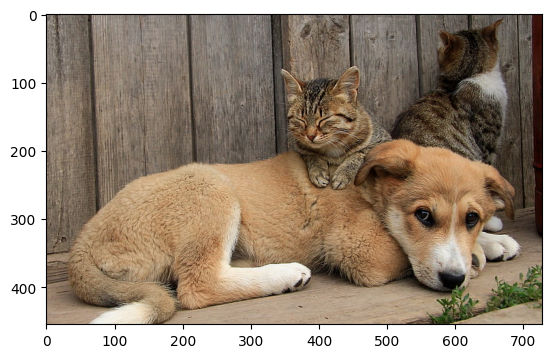

In [13]:
path_to_img = '../data_and_models/images/cat_and_dog.jpg'
# path_to_img = '../data_and_models/images/pineapple.jpg'

img = utils.read_image(path_to_img)
plt.imshow(img)

For the model, we chose the pre-trained Inception V3 architecture based on the paper "*Rethinking the Inception Architecture for Computer Vision*" ([Szegedy et al., 2015](https://arxiv.org/pdf/1512.00567.pdf)) and available in the PyTorch library.
Inception V3 improved upon its predecessor by incorporating smaller kernel size, factorized convolution, auxiliary classifier, and batch normalization to improve efficiency, reduce computational cost, and combat the vanishing gradient problem.

In [14]:
model = models.inception_v3(weights=Inception_V3_Weights.DEFAULT)

## Now, what does my model actually think is important in the data?

We prepared a small [Introduction to LIME](https://xai-tutorials.readthedocs.io/en/latest/_model_agnostic_xai/lime.html) for you, to help you understand how this method works.

Basically, LIME constructs a surrogate linear regression model to approximate black-box predictions on one observation and neighborhood of the observation.

But let's see what does this means for image classification. If you want to now more, the paper [What Does LIME Really See in Images?](http://proceedings.mlr.press/v139/garreau21a/garreau21a.pdf) provides a detailed explanation of this method, but let's summarize the main concepts. On images, LIME works by changing regions of an image, turning them on or off, and re­running inferences on this perturbed image to see which regions are most influential to the model’s prediction, by computing how much the model predictions change.

**How do we create the image perturbation?**

LIME segments the image into regions called **superpixels**, i.e. subdivides the image into $d$ subregions also called **interpretable components**. By default, LIME uses the *quickshift* algorithm to produce these superpixels (Vedaldi and Soatto, 2008). You can choose a different segmentation algorithm by setting the ```segmentation_fn``` argument in the ```explain_instance``` method.
LIME then perturbs these interpretable components by changing the values of the pixels in each superpixel region to be gray (or taking the mean of all the pixels in the superpixel, namely mean replacement) and each of these new perturbed instances is then given to the model to generate new prediction values for the class that was originally predicted. These new predictions create a dataset that is used to train LIME’s linear model to determine how much each interpretable component contributes to the original prediction.

In the picture below we can see an example of the original image on the left and the overlay of the superpixels (yellow) in the middle. On the right, we can see some examples of perturbed images that are passed to the inference algorithm to make new predictions.

<div style="text-align:center;">
    <img src="https://www.oreilly.com/api/v2/epubs/9781098119126/files/assets/eaip_0424.png" width="700" height="500">
</div>

[Image source](https://www.oreilly.com/library/view/explainable-ai-for/9781098119126/ch04.html)

**How do we create the dataset for the surrogate model?**

LIME creates the dataset from the $n$ perturbed images. Indeed, for each newly generated example $x_i$ with $1 ≤ i ≤ n$, the superpixels are randomly switched on and off and this information is encoded in a vector $z_i ∈ \{0, 1\}^d$, where each coordinate of $z_i$
corresponds to the activation ($z_{i,j} = 1$) or inactivation ($z_{i,j} = 0$) of superpixel $j$. We call the $z_i$ the **interpretable features**. 
These perturbations are really just simple binary representations of the image indicating the “presence” or “absence” of each superpixel region. Since we care about the perturbations that are closest to the original image, those examples with the most superpixels present are weighted more than examples that have more superpixels absent. This proximity can be measured using any distance metric for images.

**How do we measure the change in the model prediction?**

The next stage of LIME is to build a surrogate model. More precisely, LIME builds a linear model with the interpretable features $z_i$ as input and the predicted outcomes $y_i:= f(x_i)$ as responses. The linear model is represented as:

$y_i = \beta_0 + \beta_1 z_{i,1} + \beta_2 z_{i,2} + \ldots + \beta_d z_{i,d} + \epsilon_i$

Here, $y_i$ is the predicted outcome for the $i$-th perturbed instance, $z_{i,j}$ is the $j$-th interpretable feature, and $ϵ_i$ is the prediction error.
In the default implementation, LIME obtains this linear model using (weighted) ridge regression. The final step involves displaying the superpixels associated with the top positive coefficients of $\hat{\beta}^\lambda _n$, where $λ$ is the regularization parameter.

We start making some transformations to ensure that the input data is in the correct format and optimized for model training and inference, if you want to know more about these transformations you can check the utils.py.

In [15]:
# Resize and center crop
pill_transf = utils.get_pil_transform()
# Transform to tensor and normalize
preprocess_transform = utils.get_preprocess_transform()

We make prediction on the batch of images throught the ```batch_predict``` function which returns a batch of predicted probabilities for each class. Then we extract the the index of the class with the highest probability in the flattened array, indicating the predicted class label.

In [16]:
pred = utils.batch_predict([pill_transf(img)], model)
pred.squeeze().argmax()

287

Click [this link](https://deeplearning.cms.waikato.ac.nz/user-guide/class-maps/IMAGENET/) to identify the class name and see if the prediction is correct.

We will use the `LimeImageExplainer()` class.

class `lime.lime_image.LimeImageExplainerExplains`:

predictions on Image (i.e. matrix) data. For numerical features, perturb them by sampling from a Normal(0,1) and doing the inverse operation of mean-centering and scaling, according to the means and stds in the training data. For categorical features, perturb by sampling according to the training distribution, and making a binary feature that is 1 when the value is the same as the instance being explained.

```explain_instance```:

Generates explanations for a prediction.
First, we generate neighborhood data by randomly perturbing features from the instance (see __data_inverse). We then learn locally weighted linear models on this neighborhood data to explain each of the classes in an interpretable way (see lime_base.py).

In [17]:
#Probably delete this

#Print more classes? ---> Check why the prediction is not very good
test_pred = utils.batch_predict([pill_transf(img)], model)
top_classes = test_pred.argsort()[0, -5:][::-1] # choose the top 5 classes
top_probabilities = test_pred[0, top_classes]

for class_label, probability in zip(top_classes, top_probabilities):
    print(f"Class {class_label}: Probability = {probability:.4f}")

Class 287: Probability = 0.4033
Class 282: Probability = 0.3843
Class 281: Probability = 0.0740
Class 292: Probability = 0.0294
Class 285: Probability = 0.0255


In [18]:
explainer = lime_image.LimeImageExplainer()
explanation = explainer.explain_instance(np.array(pill_transf(img)), 
                                         lambda images: utils.batch_predict(images, model), 
                                         top_labels=5, 
                                         hide_color=0, 
                                         num_samples=1000) # number of images that will be sent to classification fun

  0%|          | 0/1000 [00:00<?, ?it/s]

#### Plot image + LIME mask

To visualize the instance explanation, we can use the ```get_image_and_mask``` model, where we can set the following parameters:
- ```label``` – label to explain
- ```positive_only``` – if True, only take superpixels that positively contribute to the prediction of the label.
- ```negative_only``` – if True, only take superpixels that negatively contribute to the prediction of the label. If false, and so is positive_only, then both negativey and positively contributions will be taken. Both can’t be True at the same time
- ```hide_rest``` – if True, make the non-explanation part of the return image gray
- ```num_features``` – number of superpixels to include in explanation
- ```min_weight``` – minimum weight of the superpixels to include in explanation

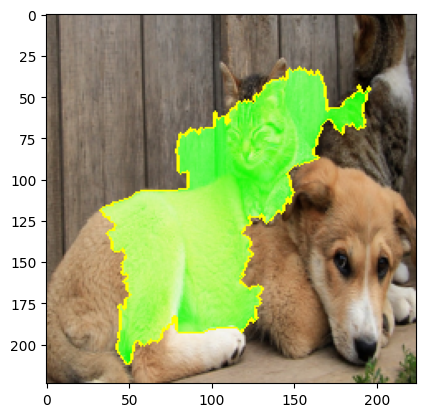

In [28]:
# Plot mask positive contributions
temp, mask = explanation.get_image_and_mask(
    explanation.top_labels[0],
    positive_only=False,
    num_features=5,
    hide_rest=False,)
img_boundry1 = mark_boundaries(temp/255.0, mask)
plt.imshow(img_boundry1)

In this first example, we set ```num_features=5``` meaning that we want to extract the top 5 features(segmented areas) that contribute most to predict the ananas, in other words, our mode heavily depends on the 5 segmented areas recognize the ananas in the image.

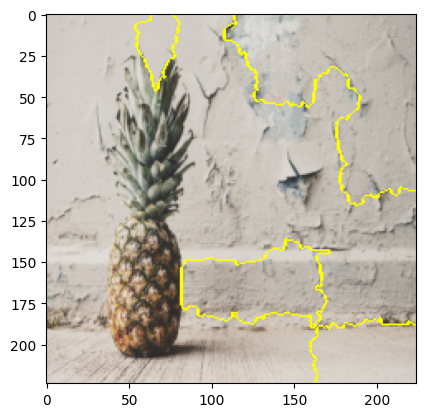

In [9]:
#Plot mask negative contributions
temp, mask = explanation.get_image_and_mask(
    explanation.top_labels[0],
    positive_only=False,
    negative_only=True,
    num_features=10,
    hide_rest=False,
    min_weight=0
)
img_boundry2 = mark_boundaries(temp/255.0, mask)
plt.imshow(img_boundry2)

<font color='green'>

#### Question 1: Which are the pros and cons of LIME?

<font color='grey'>

#### Your Answer: 

From Molnar
Pros:
1. Use of surrogate model: Even if you replace the underlying machine learning model, you can still use the same local, interpretable model for an explanation. Suppose the people looking at the explanations understand decision trees best. Because you use local surrogate models, you use decision trees as explanations without actually having to use a decision tree to make the predictions. For example, you can use a SVM. And if it turns out that an XGBoost model works better, you can replace the SVM and still use a decision tree to explain the predictions.
2. LIME is one of the few methods that work for tabular data, text, and images.
3. The fidelity measure (how well the interpretable model approximates the black box predictions) gives us a good idea of how reliable the interpretable model is in explaining the black box predictions in the neighborhood of the data instance of interest.
4. Easy implementation.

Cons:
1. The correct definition of the neighborhood is a very big, unsolved problem when using LIME with tabular data. In my opinion, it is the biggest problem with LIME and the reason why I would recommend using LIME only with great care. For each application, you have to try different kernel settings and see for yourself if the explanations make sense. Unfortunately, this is the best advice I can give to find good kernel widths.
2. Sampling could be improved in the current implementation of LIME. Data points are sampled from a Gaussian distribution, ignoring the correlation between features. This can lead to unlikely data points which can then be used to learn local explanation models.
3. The complexity of the explanation model has to be defined in advance. This is just a small complaint because in the end the user always has to define the compromise between fidelity and sparsity.
4. Another really big problem is the instability of the explanations due to the random process behind the creation of the neighborhood dataset.
5. LIME explanations can be manipulated by the data scientist to hide biases 52. The possibility of manipulation makes it more difficult to trust explanations generated with LIME.


<font color='green'>

#### Question 2: TO DO

<font color='grey'>

#### Your Answer: 